# Sentence Classifier with Feature Template

## Settings

### Feature Function
The feature function $\mathbf{f}$ uses the following features to represent a sentence: 

* Features for sentence context, each sentnece and its neighbors will have the following:
    * Number of tokens
    * Number of positive, negative and neutral tokens
    * Proportion of positive over negative
    * Proportion of negative over postive
    * Proportion of neutral 
* Feature for document context:
    * Same as the sentences but for the full document
* Labels
    * Sentence level label from DaS classifier ($y_i^s$)
    

### Training the Classifier

We select N random documents and train a DaS classifier (trained on documents) to predict the label of the sentence $y^s_i$. We create a logistic regression classifier that will be trained on data using the feature fucntion representation $P_E(y^s|\mathbf{f}(x))$.

In [12]:
## Imports 
%matplotlib inline

STRUCTURED = '/Users/maru/MyCode/structured'
IMDB_DATA='/Users/maru/MyCode/data/imdb'
SRAA_DATA='/Users/maru/MyCode/data/sraa'
TWIITER_DATA = '/Users/maru/MyCode/data/twitter'

# IMDB_DATA = 'C:/Users/mramire8/Documents/Research/Oracle confidence and Interruption/dataset/aclImdb/raw-data'

import sys
import os

sys.path.append(os.path.abspath(STRUCTURED))
sys.path.append(os.path.abspath('C:/cygwin/home/mramire8/python_code/structured/'))

import learner

from utilities.datautils import load_dataset
import experiment.base as exp


import utilities.experimentutils as exputil
import utilities.datautils as datautil
import numpy as np
import nltk
from sklearn import metrics
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.style.use('bmh')

In [13]:
## Get the data ready
import re 
vct = CountVectorizer(min_df=2, token_pattern=re.compile(r'(?u)\b\w+\b'))

# vct_doc = CountVectorizer(encoding='ISO-8859-1', min_df=2, max_df=1.0, binary=True, token_pattern='\\b\\w+\\b')
vct_doc = exputil.get_vectorizer({'vectorizer':'bow', 'limit':None, 'min_size':2})

# IMDB_DATA = 'C:/Users/mramire8/Documents/Research/Oracle confidence and Interruption/dataset/aclImdb/raw-data'

sent_tk = nltk.data.load('tokenizers/punkt/english.pickle')

imdb =  load_dataset("imdb",IMDB_DATA, keep_subject=True)

imdb.train.bow = vct_doc.fit_transform(imdb.train.data)
imdb.test.bow = vct_doc.transform(imdb.test.data)

In [14]:
class Document(object):
    def __init__(self, raw_text, lbl, sent_tk, vct_gral, sent_lbl=None):
        sentences = sent_tk.tokenize_sents([raw_text])[0]
        self.doc_label = lbl
        self.sent_bow = vct_gral.transform(sentences) # counts per sentence
        if sent_lbl is not None:
            self.sent_labels = [lbl] * len(sentences)
        else:
            self.sent_labels = sent_lbl#np.array([s.split('\t')[0] for s in self.sentences])
            
    def __init__(self,  sents_bow, sents_lbl, doc_lbl):
#         self.sentences = sents
        self.doc_label = doc_lbl
        self.sent_labels = sents_lbl
        self.sent_bow = sents_bow
        

In [15]:
def iterate_sentences(documents):
    for d in documents:
        for s in d:
            yield s
 
    
def load_documents(data, vct, sent_tk ):
    # sents, sents_bow, sents_lbl, doc_lbl
    
    sents_doc = sent_tk.tokenize_sents(data.data)
    sents_bow = [vct.transform(d) for d in sents_doc]
    sents_lbl = [[l]*len(s) for l,s in  zip(data.target, sents_doc)]
    
    x = np.array([Document(a,b,c) for a,b,c in zip( sents_bow, sents_lbl, data.target)])
    y = data.target
    return x,y

def load_documents_v2(data, vct, sent_tk, doc_clf ):
    # sents, sents_bow, sents_lbl, doc_lbl
    
    sents_doc = sent_tk.tokenize_sents(data.data)

    X = vec.fit_transform(iterate_sentences(sents_doc))
    start = 0
    sents_bow = []
    for d in sents_doc:
        end = start + len(d)
        sents_bow.append(X[start:end])
        start = end

#     sents_bow = [vct.transform(d) for d in sents_doc]
    sents_lbl = [[l]*len(s) for l,s in  zip(data.target, sents_doc)]
    
    x = np.array([Document(a,b,c) for a,b,c in zip( sents_bow, sents_lbl, data.target)])
    y = data.target
    return x,y


def features_per_document(doc, doc_clf, feature_fn, top=10, threshold=.47):
    x = np.vstack((feature_fn(doc, i, doc_clf, top=top, threshold=threshold) for i in range(len(doc.sent_labels))))
    return x

def get_training_sentence(documents, doc_clf, feature_fn, top=10, threshold=.47):
    x = np.vstack((features_per_document(d, doc_clf, feature_fn, top=top, threshold=threshold) for d in documents))
    return x[:,:-1], x[:,-1]
    
      

In [16]:
from sklearn.linear_model import LogisticRegression

x,y = load_documents(imdb.train, vct_doc, sent_tk)


doc_clf = LogisticRegression(penalty='l1', C=1)
doc_clf.fit(imdb.train.bow, imdb.train.target)



LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr',
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0)

In [17]:
# Testing document classifier

print "Document-doc accuracy: %.4f" % metrics.accuracy_score(imdb.test.target, doc_clf.predict(imdb.test.bow))
print "Test size: %s" % imdb.test.bow.shape[0]

Document-doc accuracy: 0.8884
Test size: 24989


In [18]:
# Testing Document-sentence 
# Sentences take label of the document

def doc_to_sents(docs_text, doc_labels, vct):
    '''Create bow features for sentences of one document'''
    
    sent_splitter = nltk.data.load('tokenizers/punkt/english.pickle')
    doc_sents = sent_splitter.tokenize_sents(docs_text)
    sizes = [len(d) for d in doc_sents]
    labels = [[l]*s for l, s in zip(doc_labels, sizes)]
    
    sents_bow = vct.transform(iterate_sentences(doc_sents))
    labels = np.array([l for l in iterate_sentences(labels)])
    
    return sents_bow, labels

test_sx, test_sy = doc_to_sents(imdb.test.data, imdb.test.target, vct_doc)
print "Document-sentence accuracy: %.4f" % metrics.accuracy_score(test_sy, doc_clf.predict(test_sx))
print "Test size: %s" % len(test_sy)

Document-sentence accuracy: 0.6511
Test size: 304952


In [19]:
# Testing sentence to sentence
train_sx, train_sy = doc_to_sents(imdb.train.data, imdb.train.target, vct_doc)
s2s_clf = LogisticRegression(penalty='l1', C=1)
s2s_clf.fit(train_sx, train_sy)
print "Sent-doc accuracy: %.4f" % metrics.accuracy_score(imdb.test.target, s2s_clf.predict(imdb.test.bow))
print "Sent-sentence accuracy: %.4f" % metrics.accuracy_score(test_sy, s2s_clf.predict(test_sx))
print "Test size: %s" % len(test_sy)

Sent-doc accuracy: 0.9005
Sent-sentence accuracy: 0.6982
Test size: 304952


In [20]:
## Neutrality and accuracy of the oracle on sentences, on training data
pred_prob = doc_clf.predict_proba(train_sx)
pred_sent = doc_clf.predict(train_sx)
unc_sent = 1- pred_prob.max(axis=1)
thres = 0.42
pred_sent[unc_sent > thres] = 2
print "Perc. neutrals: %s" % (1. * len(pred_sent[unc_sent > thres]) / len(pred_sent))
non_neu = pred_sent < 2
print "Accuracy: %s" % (metrics.accuracy_score(np.array(train_sy)[non_neu], pred_sent[non_neu]))


Perc. neutrals: 0.24362343236
Accuracy: 0.719345782882


In [138]:
from sklearn.base import BaseEstimator,  TransformerMixin,ClassifierMixin
from scipy.sparse import csr_matrix
from scipy.sparse import vstack, hstack


class ContextVectorizer(BaseEstimator, TransformerMixin):
# class TextStats(BaseEstimator, TransformerMixin):
    """Extract features from each document for Vectorizer"""
    def __init__(self, doc_clf, vct, feature_fn,top=10, threshold=.47):
        self.doc_clf = doc_clf
        self.vct = vct
        self.feature_fn = feature_fn 
        self.top = top
        self.threshold = threshold 
        self.feature_fn = self.feature_context
        self.lexicon =  self.get_lexicon(self.doc_clf, top=self.top)
        
    def fit(self, x, y=None):
        return self

    def transform(self, documents):
        x = self.get_training_sentence(documents,  self.feature_fn, 
                                       threshold=self.threshold)

        return x

    def get_lexicon(self, clf, top=10):
        '''
        Return lexicon of top K terms according to classifier clf. 
        The function returns feat_index-class pairs
        '''
    #     feats = np.array(vct.get_feature_names())
        coefs = clf.coef_
        if coefs.shape[0] == 1:
            coefs = [-1 * coefs[0], coefs[0]]

        res = []
        for ci, cname in enumerate(clf.classes_): # for every class
            coef = coefs[ci]
            res.extend([(i, cname) for i in np.argsort(coef)[::-1][:top]])
        return res


    def get_context(self, doc, i):
        ''' Get surrounding sentences for context '''
        zero_mat = csr_matrix(doc.sent_bow[0].shape, dtype=np.int64)
        if i >= len(doc.sent_labels):
            raise Exception("This doc is not that long.")
        if len(doc.sent_labels) == 1: # there is only one sentence
            return np.array([zero_mat, doc.sent_bow[0], zero_mat])
        elif i==0: # for the first1
            return np.array([zero_mat, doc.sent_bow[0], doc.sent_bow[1]])
        elif i == len(doc.sent_labels)-1: # for the last one 
            return np.array([doc.sent_bow[i-1], doc.sent_bow[i], zero_mat])
        else: 
            return np.array([doc.sent_bow[i-1], doc.sent_bow[i], doc.sent_bow[i+1]])

    def get_sentence_label(self,  x, threshold=.4):
        '''Get a label or a neutral answer by uncertainty threshold. We use a document classifier to return the label'''

        unc = 1 - self.doc_clf.predict_proba(x).max(axis=1)
        preds = self.doc_clf.predict(x)
        preds[unc >= threshold] = 2  # assign neutral labels
        return preds


    def feature_context(self, doc, i,  threshold=.47):
        '''Feature function, context and lexicon counts, for one sentence '''
        context = self.get_context(doc, i)
#         doc_lbl = self.get_sentence_label(doc.sent_bow.sum(axis=0), threshold=self.threshold)
        doc_lbl = self.get_sentence_label(doc.sent_bow[i], threshold=self.threshold)


        n_lex = len(self.lexicon)
        n_feat = (3 * n_lex) + 1  # 2 context sentences and current sentence + label
        lex_index = [x[0] for x in self.lexicon]

        # Add context sentences + Add sentence label, predicted
        lbl_mat = csr_matrix((doc_lbl, ([0] , [0])), shape=(1, 1), dtype=np.int64)
        new_feat =  hstack([c[:,lex_index] for c in context]+[lbl_mat])

        if new_feat.shape[1] != n_feat:
            raise ValueError("Oops, convertion did not work. The features are no correct.")

        return new_feat
    

    def features_per_document(self, doc,  feature_fn,  threshold=.47):
        x = vstack([self.feature_fn(doc, i, threshold=threshold) for i in range(len(doc.sent_labels))])
        return x

    def get_training_sentence(self, documents,  feature_fn,  threshold=.47):
        x = vstack([self.features_per_document(d, feature_fn,  threshold=threshold) for d in documents])
        return x

    def set_top(top):
        self.top = top
        
    def set_unc_threshold(thr):
        self.threshold = thr 
        
        
class SentenceClassifier(BaseEstimator, ClassifierMixin):
    """Sentence Classifier. Takes data from ContextVectorizer"""
    def __init__(self):
        self.clf = LogisticRegression(penalty='l1', C=1)
        self.doc_clf = LogisticRegression(penalty='l1', C=1)
        
    def __init__(self, doc_clf, vct, feature_fn,top=10, threshold=.47):
        self.clf = LogisticRegression(penalty='l1', C=1)
        self.converter = ContextVectorizer(doc_clf, vct, feature_fn, top=top, threshold=threshold)
        self.threshold = threshold
        if doc_clf is not None:
            self.doc_clf = doc_clf
        else:
            self.doc_clf = LogisticRegression(penalty='l1', C=1)        
            
        
    def convert(self, x):
        xx = self.converter.transform(x)
        return xx

    def get_sentence_label(self,  x, threshold=.4):
        '''Get a label or a neutral answer by uncertainty threshold.'''

        unc = 1 - self.doc_clf.predict_proba(x).max(axis=1)
        preds = self.doc_clf.predict(x)
        preds[unc >= threshold] = 2  # assign neutral labels
        return preds

    def get_label(self,  x, threshold=.4):
        '''Get a label or a neutral answer by uncertainty threshold.'''

#         unc = 1 - self.clf.predict_proba(x).max(axis=1)
#         preds = self.clf.predict(x)
#         preds[unc >= threshold] = 2
#         return preds
        return self.clf.predict(x)
    
    def fit(self, x,y):

        docx = np.vstack([d.sent_bow.sum(axis=0) for d in x])
        docy = np.array([d.doc_label for d in x])
        
        self.doc_clf.fit(docx,docy)
        self.converter.doc_clf=self.doc_clf
        xx = self.convert(x)

        
        self.fit2(xx,y)
        return self
    
    def fit2(self, X, y):
        self.clf.fit(X,y)
        self.classes_ = self.clf.classes_        
        return self
    
    def predict(self, X):
        xx = self.convert(X)
        return self.predict2(xx)


    def predict2(self, X):
        pred = self.get_label(X, threshold=self.threshold)
        return pred

    def predict_proba(self, X):
        xx = self.convert(X)
        return self.predict_proba2(xx)

    def predict_proba2(self, X):
        return self.clf.predict_proba(X)


In [95]:
## Convert testing documents 
te_x, te_y = load_documents(imdb.test, vct_doc, sent_tk)
print "%s" % (len(te_x))


24989


## Implement

* create a training funtion for data with label from te document 
* create a function for data from amt with original labels (should work for other data as well)
* create a fnction for testing same as training options 
* create a cv test 
* create a plot with cv
* test base liens
* test classifiers
* test classifier with simple fieatures
* with features for sentiment analysis 
* with fancy features 


In [141]:
## Training with Documents
def extract_y(x):
    yy = []
    for d in x:
        yy.extend(d.sent_labels)
    yy = np.array(yy)
    return yy
    
def train_clf(x, y, clf, convert=False):
    if y is None:
        yy = extract_y(x)
    else: 
        yy = y
        
    if convert:
        clf.fit(x, yy)
    else:
        clf.fit2(x,yy)
        
    return clf

def test_clf(x, y, clf, convert=False):
    '''
    Effective accuracy and neutrality percentage test
    :param x: list of Document instances
    '''
    if y is None:
        yy = extract_y(x)
    else:
        yy = y
    
    if convert:
        pred = clf.predict(x)
    else:
        pred = clf.predict2(x)

    non_neu = pred < 2

    return {'accu':metrics.accuracy_score(yy[non_neu], pred[non_neu]), 'neutrals':1- 1.* sum(non_neu) / len(pred), 'train_size':x.shape[0]}

s = SentenceClassifier(doc_clf, vct_doc, None, top=2500, threshold=.4)
ss = train_clf(x[:10], None, s, convert=True)
print test_clf(x[:10], None, ss, convert=True)

    

{'accu': 0.81147540983606559, 'train_size': 10, 'neutrals': 0.0}


In [98]:
# %%timeit
train_x = s.converter.transform(x)
train_x = train_x.tocsr()
train_y = extract_y(x)
sent_len = np.array([d.sent_bow.shape[0] for d in x])
print train_x.shape
print train_y.shape
print len(sent_len)

(311296, 15001)
(311296,)
24991


In [100]:
def sent_iterator(data, sizes, order):
    for i in order:
        yield get_sents(data, sizes,i)

def get_sents(data, sizes, i):
    ranges =  np.cumsum(sizes)
#     print 0 if i==0 else ranges[i-1],ranges[i]
    return data[0 if i==0 else ranges[i-1]:ranges[i]]

        
def experiment_v2(x, y, train_fn, test_fn, clf, train_sizes=np.linspace(.1,1.,5), n_folds=5, seed=12222, sent_size=None):

    cross_val = cv.KFold(len(sent_size), n_folds=n_folds, shuffle=True, random_state=seed)
    
    test_scores = []

    for train_index, test_index in cross_val:
        trial_score = []
        #stack matrix in order of training
        trainx = vstack([d for d in sent_iterator(x, sent_size, train_index[:max(train_sizes)])])
        trainy = np.hstack((d for d in sent_iterator(y, sent_size, train_index[:max(train_sizes)])))

        testx = vstack([d for d in sent_iterator(x, sent_size, test_index)])
        testy = np.hstack((d for d in sent_iterator(y, sent_size, test_index)))
        
        for size in train_sizes:
            adj_size = sum([s for s in sent_size[train_index[:size]]])
            print adj_size, 
            trained = train_fn(trainx[:adj_size], trainy[:adj_size],clf, convert=False)
            
            trial_score.append(test_fn(testx, testy, trained, convert=False))
            
            print "Accuracy: %s" % trial_score[-1]
        test_scores.append(trial_score)
#     print test_scores
    test_scores_mean = np.mean([[s['accu'] for s in t] for t in test_scores], axis=0)
    test_scores_std = np.std([[s['accu'] for s in t] for t in test_scores], axis=0)
    

    return test_scores, test_scores_mean, test_scores_std
sizes = [10, 50] + range(100, 3000, 250)
scores, mean, std = experiment_v2(train_x,train_y, train_clf, test_clf, s,sent_size=sent_len,n_folds=5, train_sizes=sizes)

115 Accuracy: {'accu': 0.9698562079013997, 'train_size': 62799, 'neutrals': 0.0}
585 Accuracy: {'accu': 0.96979833699703721, 'train_size': 62799, 'neutrals': 0.00033440022930297797}
1242 Accuracy: {'accu': 0.96943669827105405, 'train_size': 62799, 'neutrals': 0.0007006480994919961}
4270 Accuracy: {'accu': 0.96719683500712761, 'train_size': 62799, 'neutrals': 0.0058281182821382504}
7455 Accuracy: {'accu': 0.9681202959459243, 'train_size': 62799, 'neutrals': 0.0035032404974602027}
10696 Accuracy: {'accu': 0.96815785269212329, 'train_size': 62799, 'neutrals': 0.0033280784725870927}
13889 Accuracy: {'accu': 0.96813811607627687, 'train_size': 62799, 'neutrals': 0.0029459067819551654}
16818 Accuracy: {'accu': 0.96749268105392827, 'train_size': 62799, 'neutrals': 0.004617907928470166}
20230 Accuracy: {'accu': 0.96744208370664275, 'train_size': 62799, 'neutrals': 0.004697527030685156}
23446 Accuracy: {'accu': 0.96798683032860244, 'train_size': 62799, 'neutrals': 0.0036784025223332018}
26497 Ac

In [156]:
## Get learning curve data
from sklearn import cross_validation as cv
from sklearn.learning_curve import learning_curve


def experiment(x, y, clf, train_sizes=np.linspace(.1,1.,5), n_folds=5, seed=12222):
#     clf = SentenceClassifier(doc_clf, vct_doc, None, top=2500, threshold=.42)
#     cv = cv.ShuffleSplit(len(y), n_iter=5, test_size=.0, random_state=12345)
    cross_val = cv.KFold(len(y), n_folds=n_folds, shuffle=True, random_state=seed)
    
    test_scores = []
        
    for train_index, test_index in cross_val:
        trial_score = []
        print "Train size: %s, Test size: %s" % (len(train_index), len(test_index))
#         x_test = clf.converter.transform(x[test_index])
        te_yy = extract_y(x[test_index])
        for size in train_sizes:
            yy = extract_y(x[train_index[:size]])
            clf.fit(x[train_index[:size]],yy)

#             train_score.append(metrics.accuracy_score(y[test_index], trained.predict2(x_test)))
            
            trial_score.append(metrics.accuracy_score(te_yy, clf.predict(x[test_index])))


            print "Accuracy: %s" % trial_score[-1]
        test_scores.append(trial_score)
    
    test_scores_mean = np.mean([t['accu'] for t in test_scores], axis=0)
    test_scores_std = np.std([t['accu'] for t in test_scores], axis=0)
    

    return test_scores, test_scores_mean, test_scores_std 



In [ ]:
sizes = [10, 50] + range(100, 3000, 250)
scores, mean, std = experiment(x, y, s, n_folds=5, train_sizes=sizes)

Train size: 19992, Test size: 4999
Accuracy: 0.507380690775
Accuracy: 0.494991958471
Accuracy: 0.499832799885
Accuracy: 0.531887450437

In [82]:

# print [get_sents(r,[10,5,5,10,20], i) for i in range(0,5,1)]
print sent_len[:4]
print np.cumsum(sent_len[:4])
print get_sents(train_x, sent_len, 3).shape
type(x[0].sent_bow)
# print np.cumsum(sent_len[:3])


[11 16 13 15]
[11 27 40 55]
(15, 15001)


scipy.sparse.csr.csr_matrix

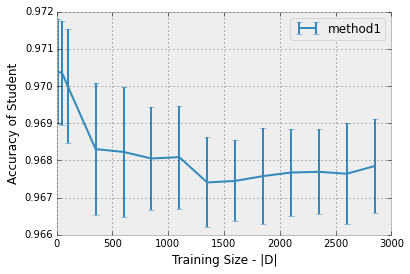

In [101]:
def exp_plot(results, sizes=None):
    
    for m, res in results.items():
        avg = res['mean']
        std = res['std']# / np.sqrt(5)
#         plt.plot(sizes,avg,  label=m)
        plt.errorbar(sizes,avg,yerr=std, label=m)
    plt.legend(loc='best')
    plt.xlabel('Training Size - |D|')
    plt.ylabel('Accuracy of Student')
            
exp_plot({'method1':{'mean':mean, 'std':std}}, sizes=sizes)





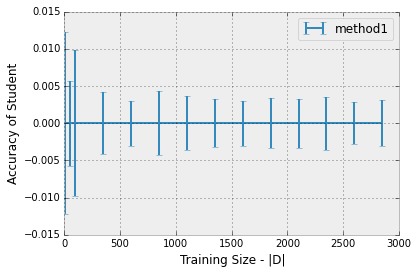

In [35]:
exp_plot({'method1':{'mean':np.mean([[s['neutrals'] for s in t] for t in scores], axis=0), 'std':std}}, sizes=sizes)

In [ ]:
def feature_no_context_counts():
    '''Feature function, counts without context of sentences, but includes document label.'''

    doc_lbl = self.get_sentence_label(doc.sent_bow.sum(axis=0), threshold=threshold)
    n_feat = doc.sent_bow[0].shape[1] +1

    # Sentence counts + document label, predicted
    lbl_mat = csr_matrix((doc_lbl, ([0] , [0])), shape=(1, 1), dtype=np.int64)
    new_feat =  hstack([doc.sent_bow[i]] + [lbl_mat])

    return new_feat

def get_sentiment_sentence(x, ...)

def feature_no_context_sentiment():
    pass

def feature_context_counts():
    pass


def feature_context_sentiment():
    pass



##############

# Alternative Feature Spaces 

## 1. Sentiment-based Features

Based on (McDonald, 2011): 

Features are s :

In [ ]:
# Train sentence classifier
from sklearn.pipeline import Pipeline

context_vect = ContextVectorizer(doc_clf, vct_doc, feature_context ,top=2500, threshold=.45)
sent_cla = SentenceClassifier()

## Get the training data
# Get all and train classifier, fully trained
ss2s_clf = Pipeline(steps=[('context', context_vect),('estimator', sent_cla)])
ss2s_clf.fit(x, y)



In [ ]:

## Get the test data
# Transform all test
text_x,test_y = load_documents(imdb.test, vct_doc, sent_tk)
testx_ss2s = context_vect.transform(test_x)

# print "Sent-doc accuracy: %.4f" % metrics.accuracy_score(testx_ss2s[:,-1], s2s_clf.predict(testx_ss2s[:,:-1]))
print "Sent-sentence accuracy: %.4f" % metrics.accuracy_score(testx_ss2s[:,-1], s2s_clf.predict(testx_ss2s[:,:-1]))
print "Test size: %s" % (testx_ss2s.shape)



In [ ]:
# from sklearn.utils import resample
# >>> X, X_sparse, y = resample(X, X_sparse, y, random_state=0)

sent_x

# # prueba =  context_vect.transform(x[:10])
# # print prueba[:,-1]


# # prueba2 = get_training_sentence(x[:10], doc_clf, feature_context, top=10, threshold=.47)
# # print prueba2[1]


In [ ]:

sent_cla = SentenceClassifier()
clf_sent = Pipeline(steps=[('context', context_vect),('estimator', sent_cla)])

# clf_sent.fit(sub_x, sub_y)

# t_x = context_vect.transform(sub_x)
print metrics.accuracy_score(t_x[:,-1], sent_cla.predict(t_x))
print metrics.accuracy_score(t_x[:,-1], clf_sent.predict(sub_x))




In [ ]:
## train on bootstraps, test on amt data sentences
#_# train on bootstraps, test on sentences as documents 
t_x

In [ ]:
t_x.shape

# Testing on AMT Data

In [ ]:
# Load data 
from utilities.amt_datautils import load_amt_imdb
amt = load_amt_imdb(IMDB_DATA, shuffle=True, rnd=1928374, amt_labels='labels')  # should bring with training labels as the amt annotations


In [ ]:
def load_documents_amt(data, vct, sent_tk ):
    # sents, sents_bow, sents_lbl, doc_lbl
    
    sents_doc = [d.split('THIS_IS_A_SEPARATOR') for d in data.data]
    sents_bow = [vct.transform(d) for d in sents_doc]
    sents_lbl = data.target
    
    x = np.array([Document(a,b,c,d) for a,b,c,d in zip(sents_doc, sents_bow, sents_lbl, data.doctarget)])
    y = data.doctarget
    return x,y


print amt.keys()

In [ ]:
print amt.train.keys()
print len(amt.train.doctarget)

In [ ]:
# Convert document to new feature space
from scipy.sparse import vstack
from scipy.sparse import csr_matrix
from sklearn.feature_extraction.text import DictVectorizer



    
#     row = [0] * n_features
#     col = [l[0] for l in lexicon]
#     counts = d.sent_bow[:,col]
    
#     data= counts.sum(axis=0)
#     return csr_matrix( (data,(row,col)), shape=(1,n_features) )

#     csr_matrix()

def feature_simple_counts(doc, i, doc_clf):
    '''Feature function bag of words, no context'''
    return doc.sent_bow[i]
    
def featurize(documents, labels, clf_d, feature_fn):
    '''Create a feature vector from documents'''

    lexicon = get_lexicon(clf_d, top=10) 
    x = vstack((feature_fn(d, lexicon, clf_d) for d in documents))
    return x
    
def feature_counts(doc, lexicon, clf_d):
    n_features = len(lexicon) * 4 + 1
    row = [0] * n_features
    col = [l[0] for l in lexicon]
    counts = d.sent_bow[:,col]
    
    data= counts.sum(axis=0)
    return csr_matrix( (data,(row,col)), shape=(1,n_features) )


    

## Process

1. Load train and test
1. Features for train:
    1. for documents: vectorizer like before
    1. for sentences: lexicon counts
1. features for test: same as for sentences (this is amt data)
1. for every size of the bootstrap
    1. train a document classifier
    1. obtain sentences and featurize
    1. test document
    1. test sentence
    1. save results
    
### Features per sentence

1. For every document
    1. for every sentence
        1. get context, document, and label, and lexicon
        1. build a vector
        1. return vecotr

In [ ]:



def experiment(data, vct, runs, rnd=123):
    x_doc, y_doc = load_documents(data, vct)
    for train, test in cv:
        clf_d = LogisticRegression(penalty="l1", C=1)
        clf_s = LogisticRegression(penalty="l1", C=1)
        
        clf_d.fit(data.train.bow[train], data.train.target[train])




In [ ]:
def lr_predict():
    pass
def lr_fit():
    pass



